In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
def data_process(stock):
    df = pd.read_csv(stock + '.csv')
    
    # Set 'Date' as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Convert string to numerical
    df['Close/Last'] = df['Close/Last'].replace({r'\$': '', r',': ''}, regex=True).astype(float)
    
    return df['Close/Last']

# Stock data preprocessing
SPX = data_process('SPX') # S&P 500
NVDA = data_process('NVDA') # NVIDIA
TSLA = data_process('TSLA') # Tesla
AEP = data_process('AEP') # Electricity
GOLD = data_process('GOLD') # Gold

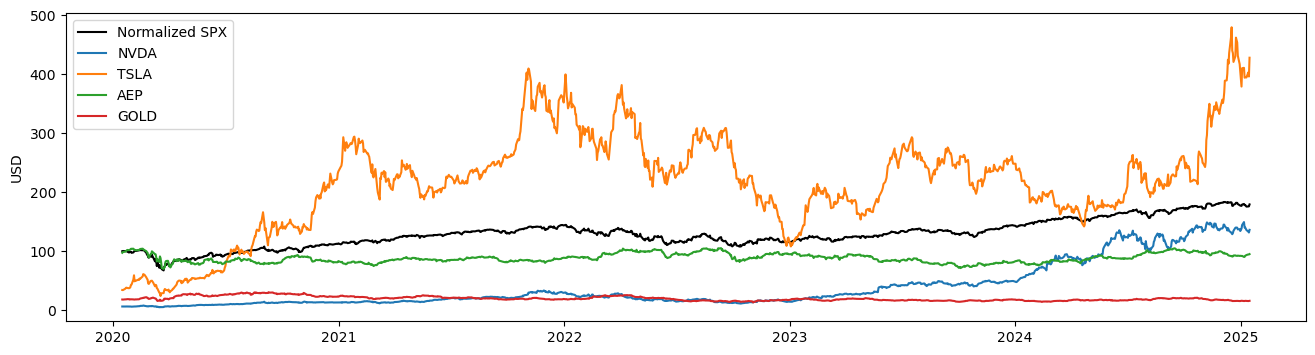

In [5]:
# S&P 500 normalization
normalized_SPX = (SPX / SPX.iloc[-1]) * 100

plt.figure(figsize=(16, 4))
plt.plot(normalized_SPX, color='k', label='Normalized SPX')
plt.plot(NVDA, label='NVDA')
plt.plot(TSLA, label='TSLA')
plt.plot(AEP, label='AEP')
plt.plot(GOLD, label='GOLD')

plt.ylabel('USD')
plt.legend()
plt.show()

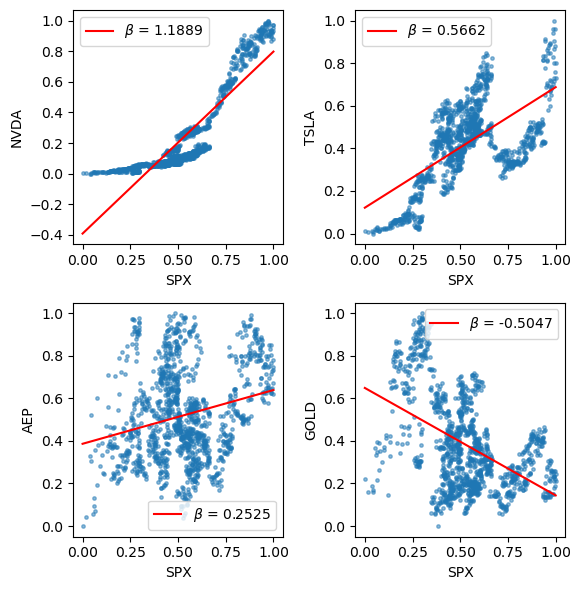

In [7]:
def scatter_plot(df, stock, ax):
    # Normalization
    SPX_n = (SPX - SPX.min()) / (SPX.max() - SPX.min())
    df_n = (df - df.min()) / (df.max() - df.min())
    
    # Linear regression
    intercept = stats.linregress(SPX_n, df_n).intercept
    slope = stats.linregress(SPX_n, df_n).slope
    x_vals = np.array([SPX_n.min(), SPX_n.max()])
    y_vals = intercept + slope * x_vals

    # Scatter plots
    ax.scatter(SPX_n, df_n, alpha=0.5, s=6)
    ax.plot(x_vals, y_vals, color='r', label=r'$\beta$ = {:.4f}'.format(slope))
    ax.set_xlabel('SPX')
    ax.set_ylabel(stock)
    ax.legend()

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
dfs = [NVDA, TSLA, AEP, GOLD]
stocks = ['NVDA', 'TSLA', 'AEP', 'GOLD']
for i, ax in enumerate(axes.flat):
    scatter_plot(dfs[i], stocks[i], ax)

plt.tight_layout()
plt.show()

In [9]:
def annual_return(df):
    DR = df.pct_change()
    ER = (1 + DR.mean()) ** 252 - 1
    sigma = DR.std() * np.sqrt(252)
    return DR, ER, sigma

def portfolio_return_2(df1, df2):
    DR_A, ER_A, sigma_A = annual_return(df1)
    DR_B, ER_B, sigma_B = annual_return(df2)
    
    w_A = np.linspace(-1, 2, 100)
    w_B = 1 - w_A
    
    ER_P = w_A * ER_A + w_B * ER_B
    sigma_P = np.sqrt(w_A**2 * sigma_A**2 + w_B**2 * sigma_B**2 + 2 * w_A * w_B * DR_A.cov(DR_B))

    return ER_P, sigma_P

def portfolio_points(df1, df2, w_A, w_B):
    DR_A, ER_A, sigma_A = annual_return(df1)
    DR_B, ER_B, sigma_B = annual_return(df2)
    
    ER_P = w_A * ER_A + w_B * ER_B
    sigma_P = np.sqrt(w_A**2 * sigma_A**2 + w_B**2 * sigma_B**2 + 2 * w_A * w_B * DR_A.cov(DR_B))
    
    return ER_P, sigma_P

def portfolio_return_3(df1, df2, df3):
    DR_A, ER_A, sigma_A = annual_return(df1)
    DR_B, ER_B, sigma_B = annual_return(df2)
    DR_C, ER_C, sigma_C = annual_return(df3)
    
    w_A = np.linspace(-1, 2, 100)
    w_B = np.linspace(-1, 2, 100)
    w_C = 1 - w_A - w_B
    
    ER_P = w_A * ER_A + w_B * ER_B + w_C * ER_C
    sigma_P = np.sqrt(w_A**2 * sigma_A**2 + w_B**2 * sigma_B**2 + w_C**2 * sigma_C**2 +
                      2 * w_A * w_B * DR_A.cov(DR_B) + 2 * w_A * w_C * DR_A.cov(DR_C) + 2 * w_B * w_C * DR_B.cov(DR_C))
    
    return ER_P, sigma_P

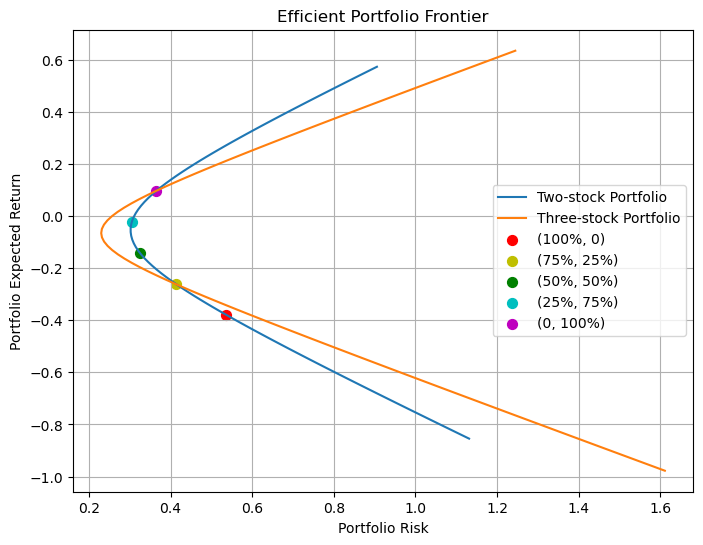

In [11]:
#Available stocks: NVDA, TSLA, AEP, GOLD
df1, df2 = NVDA, GOLD
ER_P2, sigma_P2 = portfolio_return_2(df1, df2)
ER_P3, sigma_P3 = portfolio_return_3(NVDA, AEP, GOLD)

# Plot efficient portfolio frontier
plt.figure(figsize=(8, 6))
plt.plot(sigma_P2, ER_P2, label='Two-stock Portfolio')
plt.plot(sigma_P3, ER_P3, label='Three-stock Portfolio')

# Mark points with different colors
colors = ['r','y','g','c','m']
labels = ['(100%, 0)','(75%, 25%)','(50%, 50%)','(25%, 75%)','(0, 100%)']
for i in range(5):
    w_A, w_B = 1-i/4, i/4
    ER, sigma = portfolio_points(df1, df2, w_A, w_B)
    plt.scatter(sigma, ER, color=colors[i], label=labels[i], s=50)

plt.title('Efficient Portfolio Frontier')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Expected Return')
plt.grid(True)
plt.legend()
plt.show()